PyTorch versiyonu: 2.9.0+cpu
---
✅ Master liste başarıyla yüklendi. Toplam 164798 kayıt.

Dataset ve DataLoader oluşturuluyor...
✅ DataLoader başarıyla oluşturuldu.

--- DataLoader Testi ---
Bir batch'teki resim sayısı: 16
Görüntü tensörünün şekli: torch.Size([16, 1, 256, 256])
Etiket tensörünün şekli:   torch.Size([16])


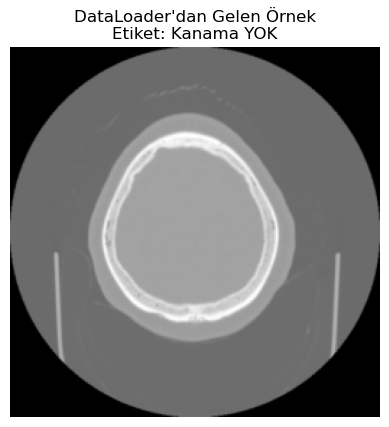

In [23]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# torchvision kütüphanesi, görüntü işleme için standart dönüşümleri içerir.
# Eğer kurulu değilse, terminalde 'pip install torchvision' komutunu çalıştırın.
import torchvision.transforms as transforms

print(f"PyTorch versiyonu: {torch.__version__}")
print("---")

# --- 1. Master Listeyi Yükle ---
MASTER_CSV_PATH = '../Data/processed/master_image_list.csv'
try:
    df_master = pd.read_csv(MASTER_CSV_PATH)
    print(f"✅ Master liste başarıyla yüklendi. Toplam {len(df_master)} kayıt.")
except FileNotFoundError:
    print(f"❌ HATA: Master liste bulunamadı. Lütfen '{MASTER_CSV_PATH}' yolunu kontrol edin.")
    # Eğer hata alırsanız, önceki notebook'u tekrar çalıştırmanız gerekebilir.

# --- 2. Görüntü Dönüşümlerini (Transforms) Tanımlama ---
# Modelimize girmeden önce her görüntüye uygulanacak standart adımlar.
# MONAI veya Albumentations gibi kütüphaneler tıbbi görüntüler için daha gelişmiş
# seçenekler sunar, ancak şimdilik PyTorch'un kendi araçlarıyla başlayalım.

IMAGE_SIZE = 256 # Modelimize tüm görüntüleri 256x256 piksel olarak vereceğiz.

# Eğitim verisi için veri artırma (data augmentation) da ekleyebiliriz.
# Şimdilik sadece temel dönüşümleri tanımlayalım.
data_transforms = transforms.Compose([
    transforms.ToPILImage(),             # Tensör veya numpy array'ini PIL Image formatına çevirir.
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Görüntüyü 256x256 boyutuna getirir.
    transforms.ToTensor(),               # Görüntüyü PyTorch tensörüne çevirir ve piksel değerlerini 0-1 arasına getirir.
    transforms.Normalize(mean=[0.5], std=[0.5]) # Piksel değerlerini -1 ile 1 arasına getirir. Bu, modelin daha stabil eğitilmesine yardımcı olur.
])

# --- 3. PyTorch için Özel Dataset Sınıfı ---

class HeadCTDataset(Dataset):
    """Kafa BT DICOM görüntüleri için özel PyTorch Dataset sınıfı."""
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'dicom_path']
        label = self.df.loc[idx, 'is_hemorrhage']
        
        try:
            dcm_file = pydicom.dcmread(img_path)
            # DICOM'daki piksel verisini al
            image = dcm_file.pixel_array
            
            # Bazen DICOM'lar renkli gelebilir (1'den fazla kanal). Siyah-beyaz olduğundan emin olalım.
            if image.ndim > 2:
                image = image[:, :, 0] # Sadece ilk kanalı al
            
        except Exception as e:
            print(f"HATA: {img_path} dosyası okunamadı. Hata: {e}")
            return None, None # Hatalı veriyi atlamak için None döndür

        # Görüntüyü doğru format olan 8-bit'e (0-255) dönüştürelim.
        # Bu, `transforms.ToPILImage()`'ın doğru çalışması için gereklidir.
        image = image.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6) # Önce 0-1 arasına getir
        image = (image * 255).astype(np.uint8) # Sonra 0-255 arasına getir
        
        # Tanımladığımız dönüşümleri uygula
        if self.transform:
            image = self.transform(image)
        
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return image, label_tensor

# --- 4. DataLoader'ı Oluşturma ve Test Etme ---

# Hatalı verileri (None) ayıklamak için özel bir fonksiyon
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

print("\nDataset ve DataLoader oluşturuluyor...")

# Önce Dataset'i oluşturalım
# Önemli: Test için verinin sadece küçük bir kısmını kullanalım (ilk 1000 resim)
# Bu, kodun hızlıca çalışıp çalışmadığını görmemizi sağlar.
test_df = df_master.head(1000)
head_ct_dataset = HeadCTDataset(dataframe=test_df, transform=data_transforms)

# Şimdi DataLoader'ı oluşturalım
# batch_size: Modele her seferinde kaç resim verileceği
# shuffle=True: Eğitim sırasında veriyi her epoch'ta karıştırır, bu modelin genelleme yapmasını sağlar.
BATCH_SIZE = 16
data_loader = DataLoader(head_ct_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

print(f"✅ DataLoader başarıyla oluşturuldu.")

# DataLoader'dan bir batch veri çekip test edelim
try:
    images, labels = next(iter(data_loader))

    print("\n--- DataLoader Testi ---")
    print(f"Bir batch'teki resim sayısı: {len(images)}")
    print(f"Görüntü tensörünün şekli: {images.shape}") # Beklenen: torch.Size([16, 1, 256, 256])
    print(f"Etiket tensörünün şekli:   {labels.shape}")   # Beklenen: torch.Size([16])

    # Batch'ten bir resmi görselleştirelim
    sample_image = images[0]
    sample_label = labels[0]

    # Normalizasyonu geri alarak görüntüyü daha anlaşılır hale getirelim
    sample_image = sample_image * 0.5 + 0.5 

    plt.imshow(sample_image.squeeze(), cmap='gray')
    plt.title(f"DataLoader'dan Gelen Örnek\nEtiket: {'Kanama VAR' if sample_label.item() == 1 else 'Kanama YOK'}")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"❌ DataLoader test edilirken bir hata oluştu: {e}")